Authors: Taylor Larkin, Mackenzie McPike
<br>
Version Date: 2025-02-05

# Geometric Deep Learning Featurizer for Tabular Data: <br>A DataRobot Custom Transformer Using GraphSAGE


Tabular data is one of the most common structures used in machine learning; however, many real-world problems involve relationships between entities that are better captured using graph structures. Graph data represents entities as nodes and relationships as edges, making it a powerful tool for capturing relational dependencies. Common use cases for graph-based learning are social networks, recommendation systems, fraud detection, and molecular property prediction. In these applications, [geometric deep learning](https://graphics.stanford.edu/courses/cs233-18-spring/ReferencedPapers/GCNN_Geometric%20deep%20learning-%20going%20beyond%20Euclidean%20data.pdf) techniques (i.e., the application of deep learning approaches to non-Euclidean data like graphs) have grown in popularity. Deep learning techniques are particularly well-suited to studying this type of information due to the ability to learn representations automatically, especially with unstructured data.

Despite the advantages provided by graph-based learning techniques, they are often overlooked for traditional tabular data&mdash;potentially due to the question of _how_ to represent tabular data in a graph. To answer this question, [k-Nearest Neighbors (kNN) graphs](https://en.wikipedia.org/wiki/Nearest_neighbor_graph) and similar methods can convert a tabular dataset into a graph representation. This notebook illustrates how to leverage geometric deep learning to extract graph-based features and enrich datasets for supervised tasks by:

- Converting a tabular dataset into a graph representation using kNN graphs,
- Training a [GraphSAGE](https://arxiv.org/pdf/1706.02216)-based neural network to generate unsupervised node embeddings,
- Packaging the solution as a DataRobot Custom Transformer, and
- Evaluating the impact on downstream machine learning tasks in DataRobot.

To implement this process, this notebook includes the following steps:

1. Install the DataRobot API, import libraries, and connect to DataRobot.
2. Load the example data.
3. Execute the custom transformer locally in the notebook.
4. Execute the custom transformer via DRUM.
5. Execute the custom transformer inside DataRobot.

### Install the DataRobot API

For more information on the installation process, follow the [API quickstart guide](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html).

In [1]:
# !pip install datarobot

### Import libraries

In [2]:
import datarobot as dr
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Connect to DataRobot

For more information on the available connection options, review the documentation on [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [3]:
# Connect to DataRobot
dr.Client()

### Load data from scikit-learn

To demonstrate the application of this custom transformer, first, load the [diabetes example dataset from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes), commonly used for regression tasks. This dataset contains 10 features characterizing of a few hundred diabetes patients, with the target being a quantitative measure of disease progression. Because each row is a patient, it's reasonable to assume there may be some important relationships between rows, something that our transformer can help capitalize on for potentially better predictions.

In [4]:
# Loading dataset
df = load_diabetes(as_frame=True, scaled=False)["frame"]
df.to_csv("./sklearn_diabetes.csv", index=False)
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


### Execute the transformer locally

The first step in this process is to create a [custom task](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-custom-tasks.html#create-custom-tasks). Custom tasks are DataRobot assets executing custom code, either an estimator (i.e., an algorithm that makes the prediction) or a transformer (i.e., a set of preprocessing steps), in Python or R. You can find examples of these tasks in the [DataRobot User Models repository](https://github.com/datarobot/datarobot-user-models/tree/master/task_templates); however, this notebook uses a transformer written in Python.

For a DataRobot custom task implementing a transformer, you need _at least_ two files:

- `custom.py`: contains the necessary code as a python class to perform the desired task.
- `model-metadata.yaml`: contains metadata regarding the task, including information such as the types of data supported and the adjustable [hyperparameters](https://docs.datarobot.com/en/docs/modeling/automl-preview/cml-hyperparam.html#configure-hyperparameters-for-custom-tasks).

These assets are listed in the reference materials for this AI Accelerator. In the `custom.py` file, the class contains a `fit()` method and a `transform()` method, similar to the scikit-learn API. To understand how the embeddings are generated for this particular transformer, review the docstrings and code. Note that at a high-level, the steps are:

1. `fit()`: Train the GraphSAGE model.
   - Converts the input tabular dataset (Pandas DataFrame) into a NumPy array.
   - Stores the original training features for later use.
   - Constructs a kNN graph using the training features.
   - Instantiates a GraphSAGE model with:
       - Input features (_in_channels_)
       - Hidden layer (_hidden_channels_)
       - Output embedding size (_out_channels_)
   - Trains the GraphSAGE model in an unsupervised manner using a contrastive loss:
       - Maximizes similarity between connected nodes.
       - Minimizes similarity between randomly sampled nodes.
   - Stores the trained model for later use in the transformation phase.
  
2. `transform()`: Generate graph-based embeddings.
   - Converts the new input tabular dataset (Pandas DataFrame) into a NumPy array.
   - Combines the stored training data with the new data to build an updated kNN graph.
   - Runs the trained GraphSAGE model on the combined graph to generate node embeddings.
   - Extracts only the embeddings corresponding to the new data.
   - Returns a Pandas DataFrame where each row corresponds to a rows' learned graph embedding.

Ultimately, the class automatically converts tabular data into a graph using kNN. It then learns meaningful feature representations (embeddings) for each row using GraphSAGE. These learned embeddings capture relational information between rows and serve as new features for downstream machine learning tasks. With the help of the DataRobot `TransformerInterface`, this approach can be used directly in DataRobot [blueprints](https://docs.datarobot.com/en/docs/workbench/wb-experiment/wb-ml-experiment/ml-experiment-insights/ml-blueprint.html#blueprint). With this functionality implemented in DataRobot, practitioners can apply this approach to _any_ DataRobot blueprint that supports [Composable ML](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/index.html#composable-ml).

First, let's demonstrate this task on the dataset locally. For a comparison, you'll also train a random forest with and without the embedding features to compare the performance differences.

In [5]:
# Load task
from custom import CustomTask

CustomTask()

In [6]:
# Split data into training and testing sets
y = df.pop("target").values
X = df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [7]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Use the CustomTask transformer to generate graph embeddings.
transformer = CustomTask()
transformer.fit(
    X=pd.DataFrame(X_train_scaled),
    y=pd.Series(y_train),
    parameters={
        "hidden_channels": 32,
        "out_channels": 16,
        "k_neighbors": 10,
        "learning_rate": 0.01,
        "epochs": 200,
        "num_neg_samples": 10,
        "random_seed": 10,
    },
)
train_embeddings = transformer.transform(pd.DataFrame(X_train_scaled))
test_embeddings = transformer.transform(pd.DataFrame(X_test_scaled))

# Let's take a look at what the embeddings look like
train_embeddings

Epoch  20/200, Loss: 1.0316
Epoch  40/200, Loss: 0.9796
Epoch  60/200, Loss: 0.9593
Epoch  80/200, Loss: 0.9360
Epoch 100/200, Loss: 0.9199
Epoch 120/200, Loss: 0.9105
Epoch 140/200, Loss: 0.9031
Epoch 160/200, Loss: 0.9002
Epoch 180/200, Loss: 0.9005
Epoch 200/200, Loss: 0.8851
Detected training data, returning precomputed embeddings...
Done!
Computing embeddings on test data...
Done!


,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15
0,0.714236,0.195132,-0.096318,-0.311961,0.567105,-0.489295,-0.714355,-0.024585,0.196977,0.016201,1.009107,-0.080087,-0.548613,-0.432897,0.726009,0.363837
1,0.477560,0.462061,-0.148445,-0.586951,-0.388205,-0.010829,-0.445717,0.252277,0.280596,0.373057,-1.398658,-0.722013,-0.278857,-0.192541,0.078171,-0.051825
2,-0.058149,-0.145208,0.753362,0.507179,-0.313506,-0.446512,0.011241,0.412381,0.425214,0.234929,0.022408,0.995351,-0.554609,0.201499,-0.173409,0.592128
3,0.292143,0.359675,-0.803346,0.678618,-0.559849,-0.676480,-0.043755,0.106680,0.219508,0.007725,0.374037,0.019134,0.285391,0.625514,-0.280471,-0.195961
4,0.051677,-0.817802,0.580192,-0.481930,-0.106930,0.276054,0.162404,0.588775,-0.471334,-0.483700,0.084235,-0.014627,0.659243,0.277238,0.380094,0.508525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0.268530,-0.083649,-0.197400,0.293427,0.580959,-0.383042,-0.052551,-0.378293,-0.620423,1.029003,0.721893,-0.475428,0.039721,-0.042064,0.718667,0.320438
349,-0.052729,0.831205,0.016622,0.124482,-0.524949,0.048507,0.472292,-0.788594,-0.455710,-0.589506,-0.231001,0.116527,-0.653135,0.535969,0.247004,-0.478116
350,0.279793,-0.961381,0.571456,0.104440,0.136330,0.130328,0.458263,0.593832,-0.433652,-0.074591,-0.234391,0.036269,0.051748,0.286048,0.366534,0.713114
351,1.041125,0.108532,-0.846148,-0.090559,0.234098,-0.028096,0.118305,-0.227486,-0.084941,-0.423038,-0.629177,-0.094369,-0.285657,0.361541,0.128632,-0.025376


In [9]:
# Train a Random Forest on original (scaled) features.
rf_baseline = RandomForestRegressor(random_state=10)
rf_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = rf_baseline.predict(X_test_scaled)
print("Original Features Only")
print("  R2:", r2_score(y_test, y_pred_baseline))
print("  RMSE:", root_mean_squared_error(y_test, y_pred_baseline))

Original Features Only
  R2: 0.4244029022010454
  RMSE: 56.45461447486483


In [10]:
# Train a Random Forest with the graph embeddings added
rf_embed = RandomForestRegressor(random_state=10)
rf_embed.fit(train_embeddings, y_train)
y_pred_embed = rf_embed.predict(test_embeddings)
print("Original Features + Graph Embeddings")
print("  R2:", r2_score(y_test, y_pred_embed))
print("  RMSE:", root_mean_squared_error(y_test, y_pred_embed))

Original Features + Graph Embeddings
  R2: 0.4430720969872657
  RMSE: 55.53152969158729


### Execute the transformer with DRUM

With this approach working locally in a notebook, proceed to ensuring the custom task works using the DataRobot [DRUM CLI tool](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-drum.html). DRUM is a productivity tool to quickly test custom tasks, models, and environments before loading them into DataRobot, detecting any potential issues through a command line tool. Provided below is the terminal command you can run to verify this custom transformer performs as expected: 

In [11]:
!drum fit --code-dir ./ --input ./sklearn_diabetes.csv --target-type transform --verbose

Detected fit mode
Starting Fit
Epoch  20/200, Loss: 228.9697
Epoch  40/200, Loss: 60.8498
Epoch  60/200, Loss: 25.8392
Epoch  80/200, Loss: 9.4194
Epoch 100/200, Loss: 4.3859
Epoch 120/200, Loss: 3.1602
Epoch 140/200, Loss: 2.6287
Epoch 160/200, Loss: 2.2042
Epoch 180/200, Loss: 2.1824
Epoch 200/200, Loss: 1.9885
Fit successful
Maximum fit memory usage: 505MB
Starting Prediction
Maximum server memory usage: 505MB
Prediction successful for fit validation
Validation Complete 🎉 Your model can be fit to your data,  and predictions can be made on the fit model! 
 You're ready to add it to DataRobot. 


### Execute the transformer in DataRobot

With a DRUM-validated custom task, proceed to uploading the custom task to DataRobot. The DataRobot documentation [details the upload process for custom tasks](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-custom-tasks.html#upload-the-task). After uploading the task, create a DataRobot project using the [Python API](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/), providing a testing ground for the featurizer. After you create a project and train models, take the top performing model blueprint, add the custom task to it, and rerun the blueprint.

One important consideration in this process is configuring the environment, as it'll be the first item to set up before uploading your `custom.py` and `model-metadata.yaml` files. One option is to start with a base environment and upload the additional packages or pin specific versions (by uploading a `requirements.txt` file). Another option is to create a [custom environment](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-custom-env.html). The latter may have performance and speed advantages, as many of the pre-built images can contain packages that aren't needed for running your task. A `requirements.txt` file is provided in the assets for this accelerator, containing the required packages for this custom transformer.

In [12]:
# Create DataRobot project
project = dr.Project.create(
    sourcedata="./sklearn_diabetes.csv", project_name="Sklearn Diabetes Dataset"
)
project

Project(Sklearn Diabetes Dataset)

In [13]:
# Remove holdout set since it's a smaller dataset and doing 5-fold cross-validation
project.set_partitioning_method(
    cv_method=dr.enums.CV_METHOD.RANDOM,
    validation_type=dr.enums.VALIDATION_TYPE.CV,
    holdout_pct=0,
    reps=5,
)

Project(Sklearn Diabetes Dataset)

In [14]:
# Kick off project
project.analyze_and_model(
    target="target",
    advanced_options=dr.AdvancedOptions(prepare_model_for_deployment=False),
    worker_count=-1,
)

# Wait for initial modeling to finish
project.wait_for_autopilot()

In progress: 8, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 2s)
In progress: 8, queued: 0 (waited: 3s)
In progress: 8, queued: 0 (waited: 4s)
In progress: 8, queued: 0 (waited: 7s)
In progress: 8, queued: 0 (waited: 11s)
In progress: 8, queued: 0 (waited: 18s)
In progress: 1, queued: 0 (waited: 32s)
In progress: 16, queued: 0 (waited: 52s)
In progress: 7, queued: 0 (waited: 73s)
In progress: 2, queued: 0 (waited: 94s)
In progress: 0, queued: 0 (waited: 114s)


In [15]:
# Take a look at the current leaderboard
models = project.get_model_records(sort_by_partition="crossValidation")
models

[GenericModel('Elastic-Net Regressor (mixing alpha=0.5 / Least-Squares Loss)'),
 GenericModel('Light Gradient Boosting on ElasticNet Predictions '),
 GenericModel('eXtreme Gradient Boosted Trees Regressor'),
 GenericModel('Generalized Additive2 Model'),
 GenericModel('RuleFit Regressor'),
 GenericModel('RandomForest Regressor'),
 GenericModel('Light Gradient Boosted Trees Regressor  (4 leaves)'),
 GenericModel('Ridge Regressor')]

In this AI Accelerator, the best blueprint contains the following tasks:

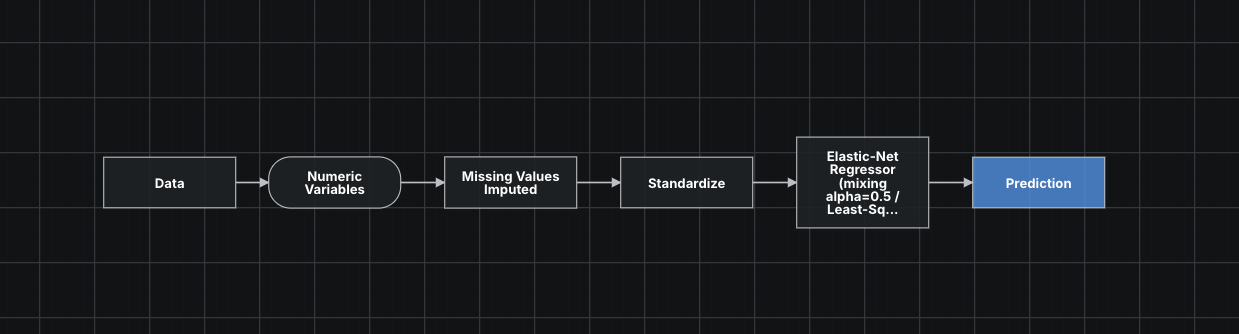

Follow the instructions to [access the blueprint editor and add the custom task](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-blueprint-edit.html#access-the-blueprint-editor):

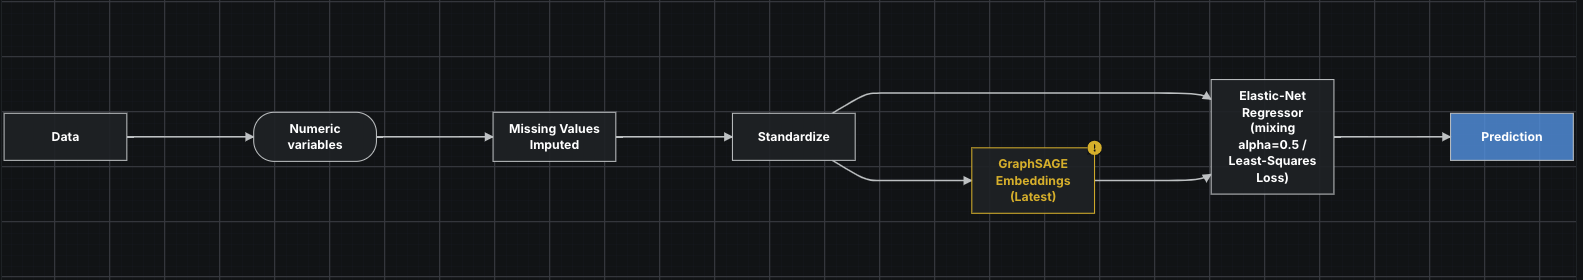

Once the modified blueprint is trained, compare it against the other blueprints on the Leaderboard:

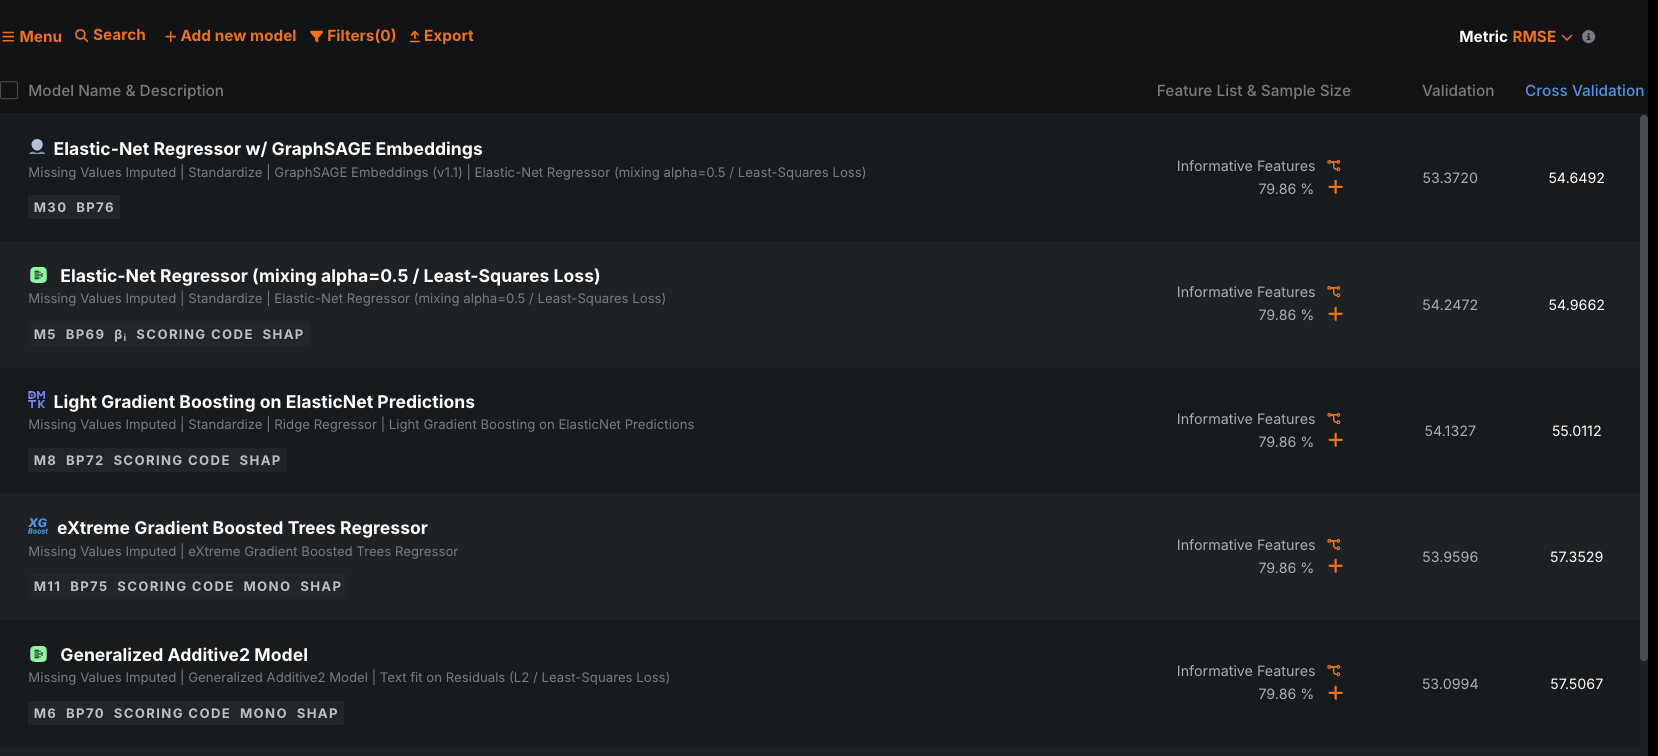

Because you specified hyperparameters in the `model-metadata.yaml` file, they are populated in the DataRobot UI and can be used to tune the blueprint:

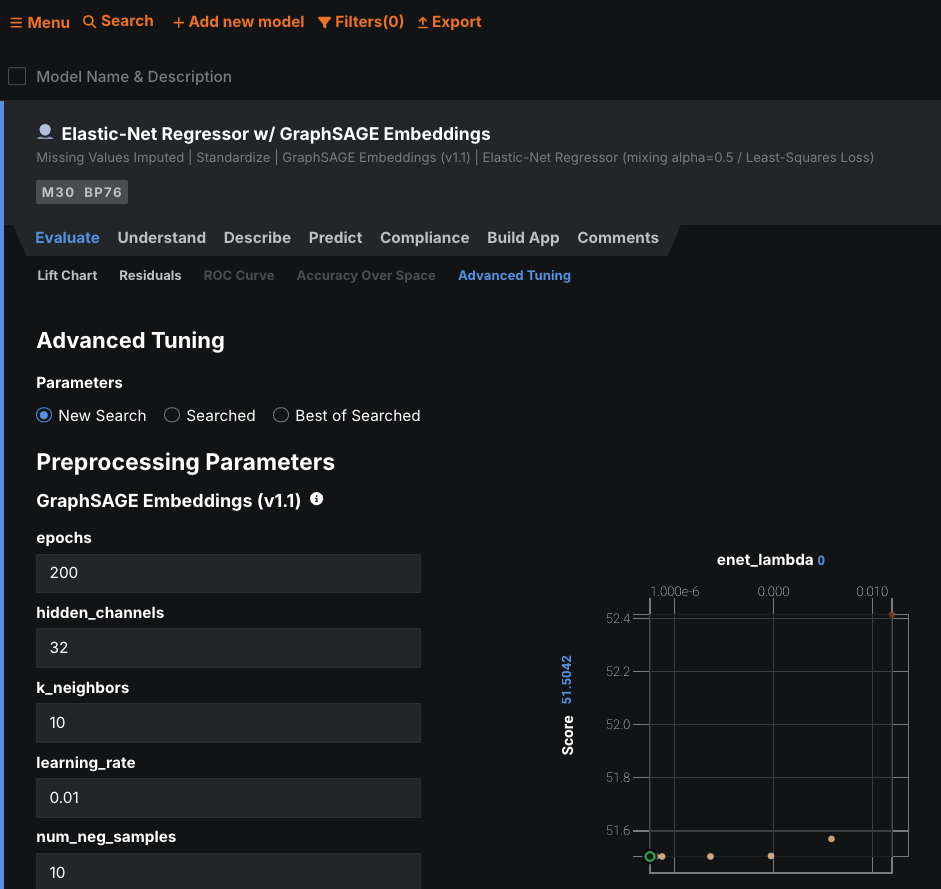

In this example, reducing the number of `k_neighbors` to 5 leads to an increase in performance:

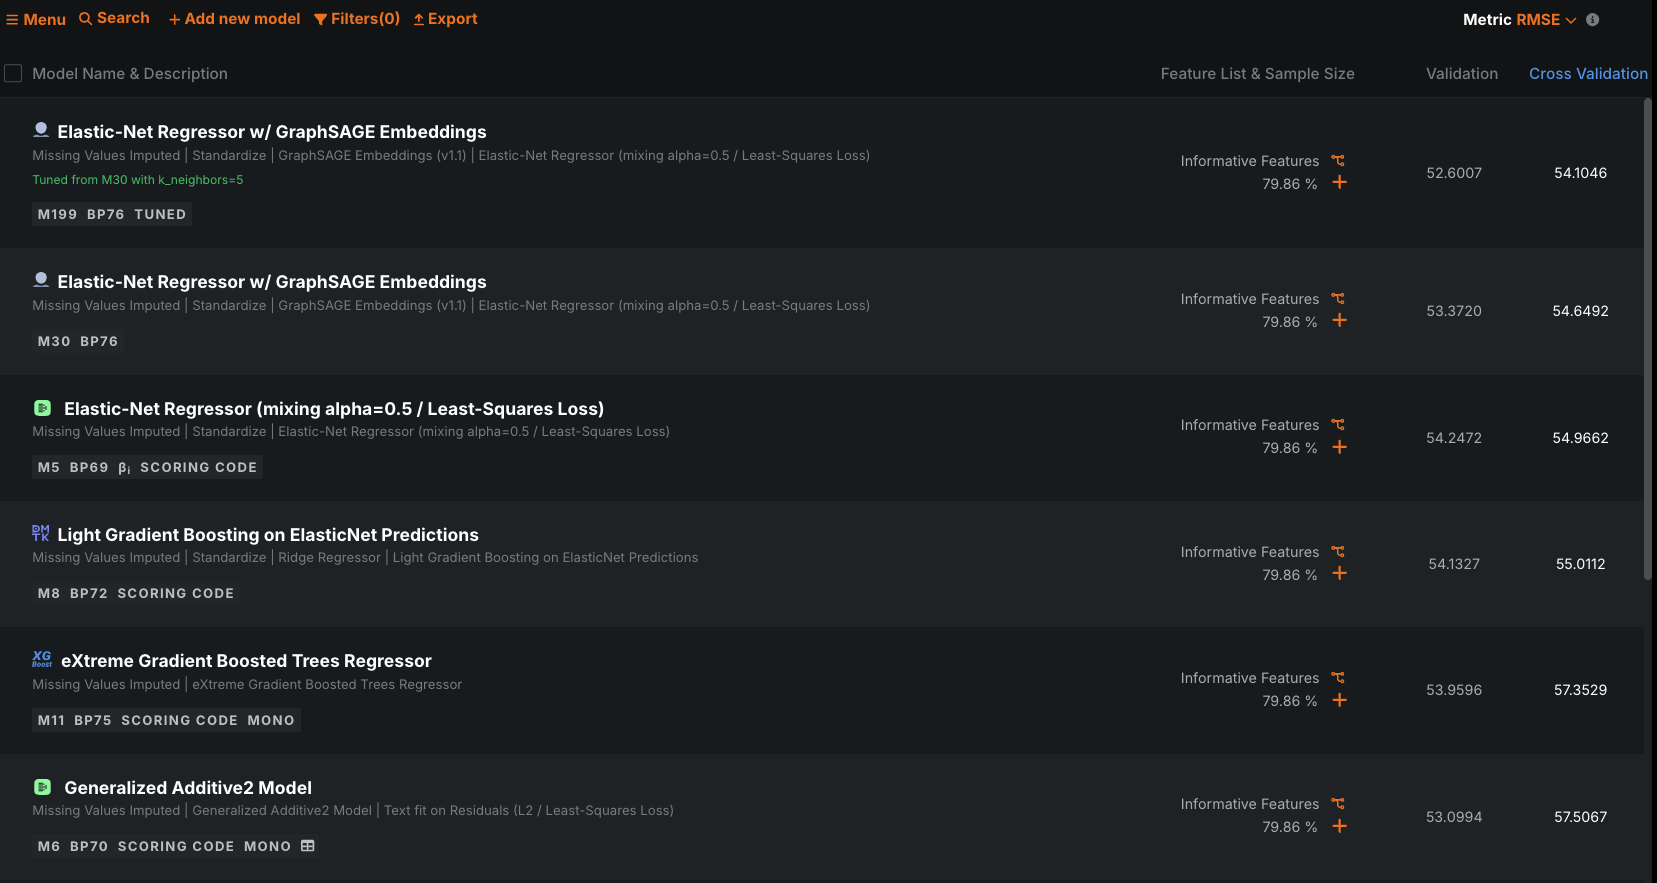

Given that elastic-net models estimate [coefficients](https://docs.datarobot.com/en/docs/modeling/analyze-models/describe/coefficients.html#coefficients-preprocessing), we can extract those to see the estimated effect associated with the embeddings (recall the embeddings are labeled _g*_) for the most accurate model:

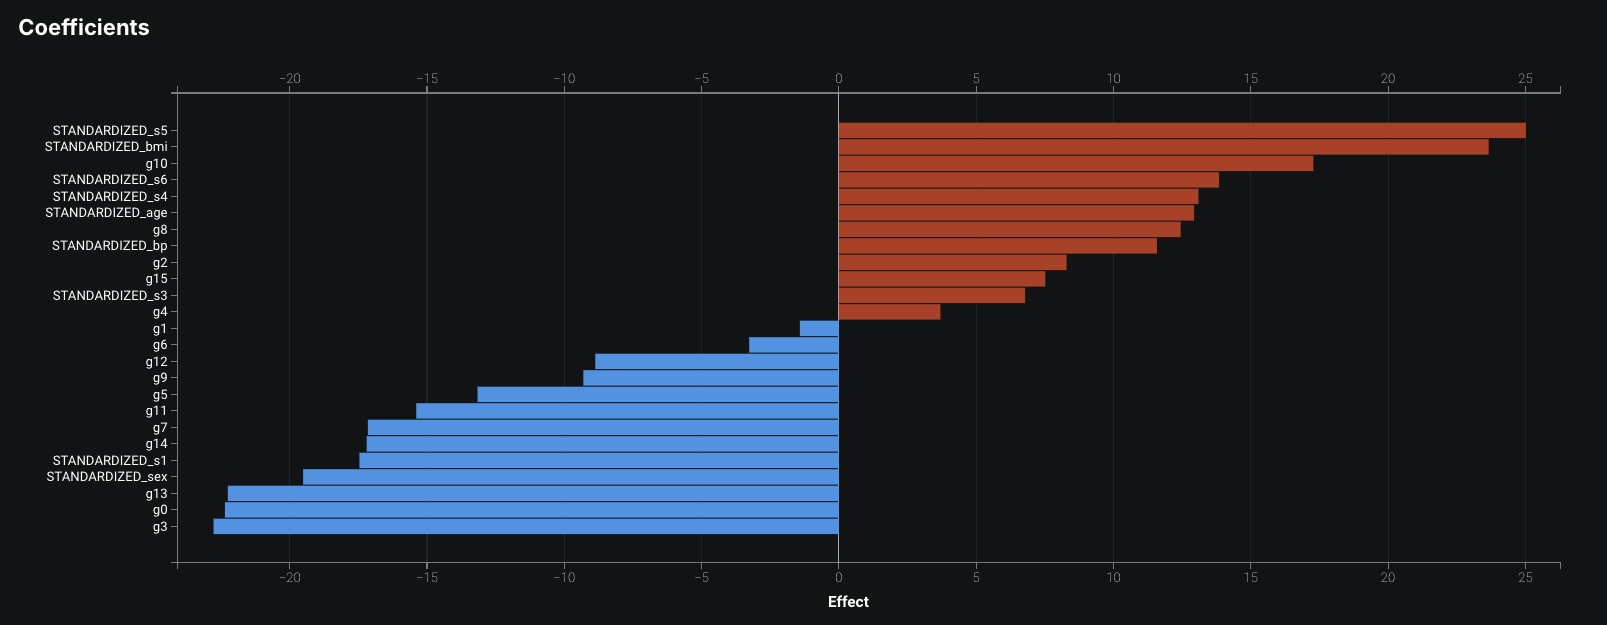

### Summary

This notebook demonstrated how geometric deep learning can be leveraged to enhance tabular data by extracting graph-based features for supervised learning. Using a kNN Graph, you transformed a tabular dataset into a structured graph representation and trained a GraphSAGE model to generate node embeddings in an unsupervised manner. These embeddings were then used as enriched features to improve downstream machine learning tasks. Additionally, this method was packaged as a DataRobot custom transformer, enabling seamless integration within DataRobot's automated machine learning pipelines. Then, this transformer was tested in three environments&mdash;locally in a notebook, using DRUM, and inside DataRobot&mdash;to ensure its effectiveness and flexibility. By applying graph-based techniques to tabular data, you can unlock new ways to capture relational structures and enhance predictive modeling in DataRobot. This approach can be extended to various datasets, offering a powerful tool for feature engineering in machine learning workflows.